# Data Cleaning and Reshaping
This first block handles the most complex task: loading the messy historical_data_2010-2020.csv file and transforming it into a clean, usable DataFrame named df.

## 1. Starting Data Cleaning and Reshaping...

Data cleaning and reshaping complete!
## 2. Inspected Cleaned Data
First 5 rows of the NEW tidy dataset:
       State  District         Year  Area (Hectare)  Production (Tonnes)  \
0  Karnataka  Bagalkot  2010 - 2011         11231.0               5708.0   
1  Karnataka  Bagalkot  2011 - 2012          7437.0               1915.0   
2  Karnataka  Bagalkot  2012 - 2013           949.0                209.0   
3  Karnataka  Bagalkot  2013 - 2014          4074.0               2129.0   
4  Karnataka  Bagalkot  2014 - 2015          6144.0               2673.0   

   Yield (Kg/Ha)   Crop  
0           0.51  Arhar  
1           0.26  Arhar  
2           0.22  Arhar  
3           0.52  Arhar  
4           0.44  Arhar  

Shape of the new dataset: (15476, 7)

New data types:
<class 'pandas.core.frame.DataFrame'>
Index: 15476 entries, 0 to 27347
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               -

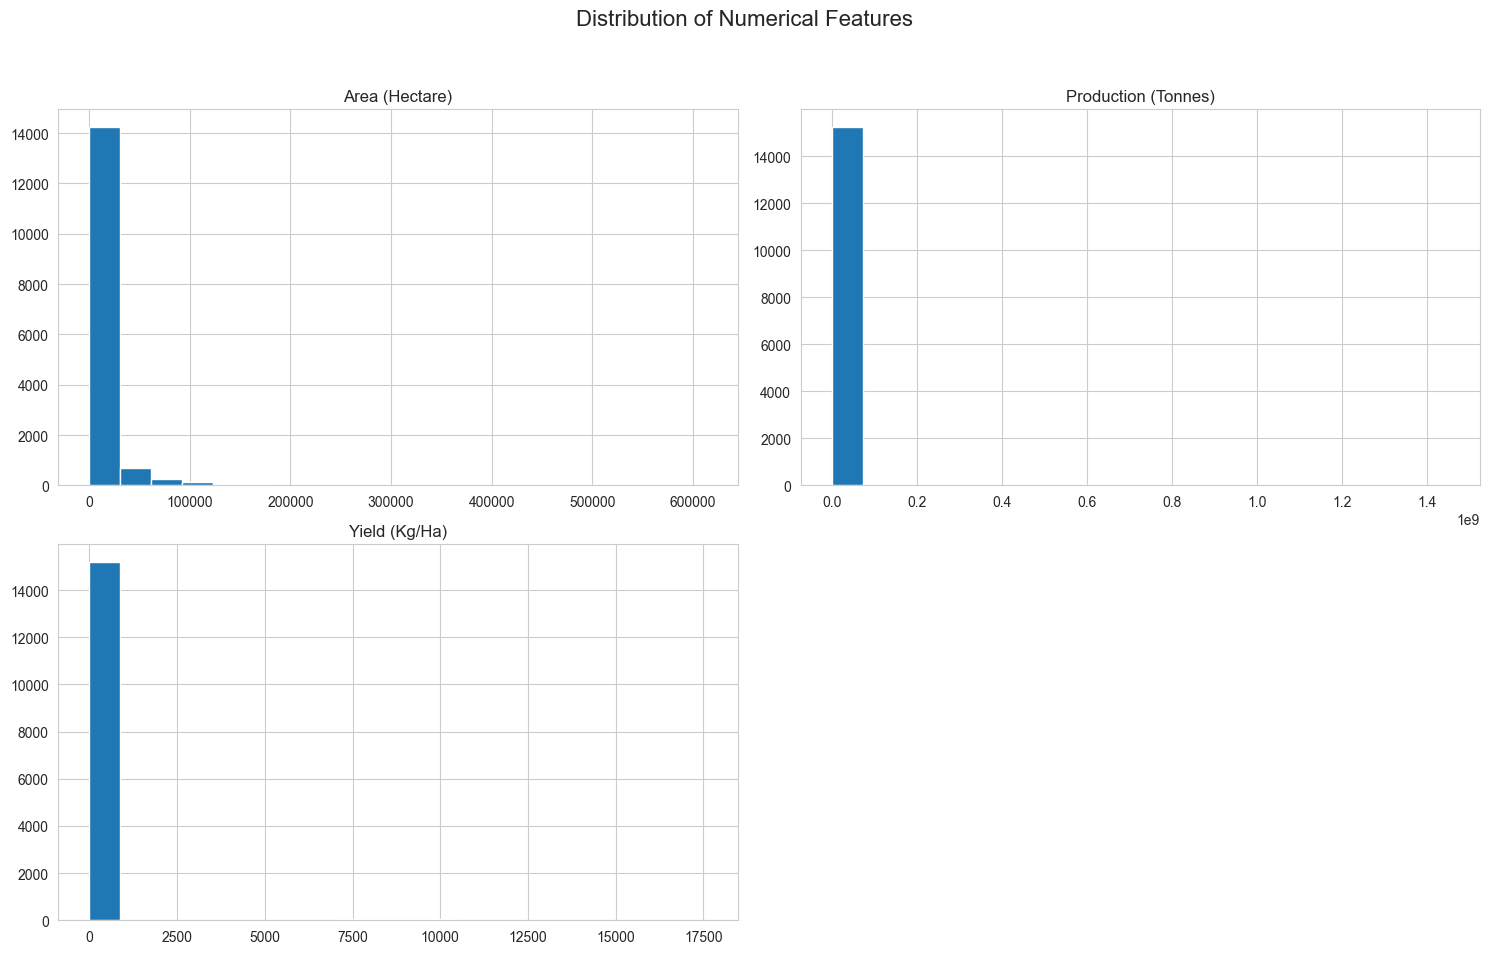

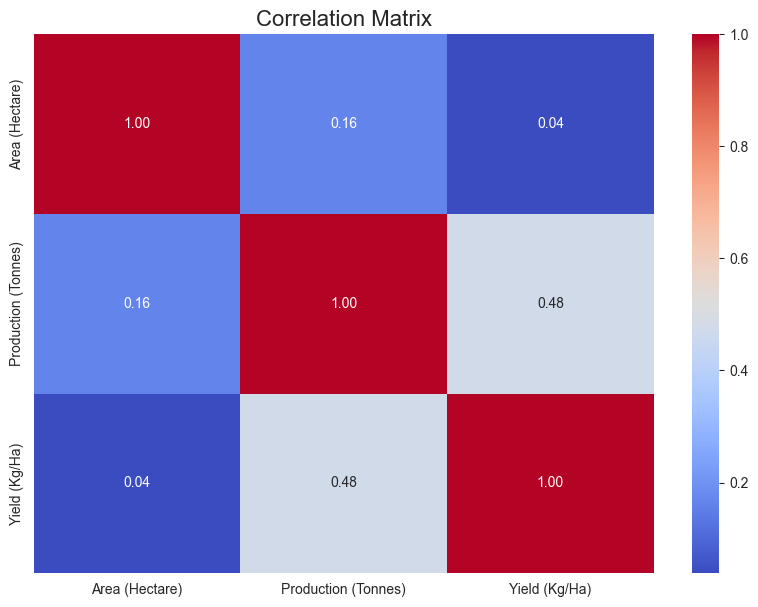

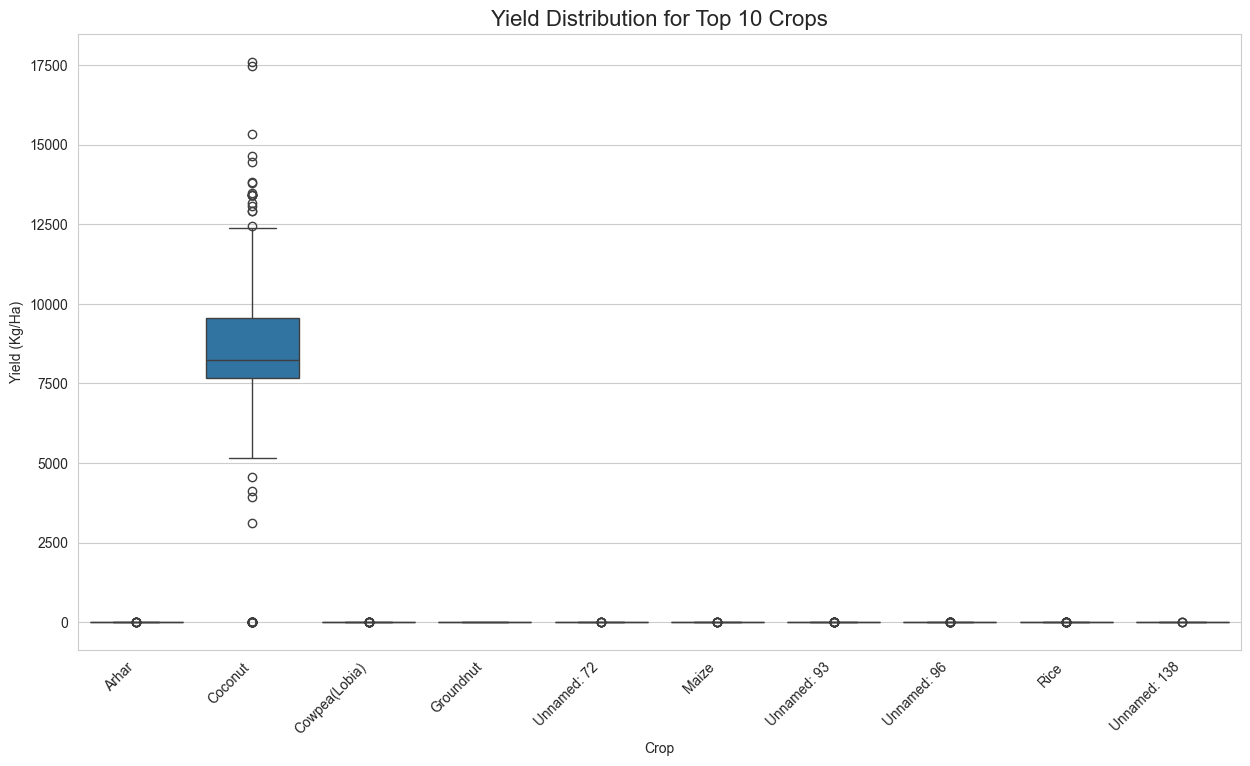

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- 1. DATA CLEANING AND RESHAPING ---
print("## 1. Starting Data Cleaning and Reshaping...")

# Load the raw data
try:
    raw_df = pd.read_csv('historical_data_2010-2020.csv')
except FileNotFoundError:
    print("Error: The file 'historical_data_2010-2020.csv' was not found.")
    exit()

# Forward-fill the identifying columns (State, District, Year)
raw_df['State'].ffill(inplace=True)
raw_df['District'].ffill(inplace=True)
raw_df['Year'].ffill(inplace=True)

# Drop the top two header rows which are now redundant
raw_df = raw_df.drop([0, 1]).reset_index(drop=True)

# Create an empty list to store clean data for each crop
tidy_data = []

# The data is in blocks of 3 columns per crop/season combination. We iterate through them.
# We start at column 3 and step by 3 until the end.
for i in range(3, raw_df.shape[1], 3):
    # Check if the column exists to prevent errors
    if i + 2 >= raw_df.shape[1]:
        continue

    # Extract crop name and season from the original multi-level header
    header_info = pd.read_csv('historical_data_2010-2020.csv', nrows=1).columns[i]
    # Simple split; assumes format like "CropName" or "CropName / OtherName"
    crop_name = header_info.split('/')[0].strip()
    
    # Define the columns for this crop block
    area_col = raw_df.columns[i]
    prod_col = raw_df.columns[i+1]
    yield_col = raw_df.columns[i+2]

    # Create a temporary dataframe for the current crop
    crop_df = raw_df[['State', 'District', 'Year', area_col, prod_col, yield_col]].copy()
    crop_df['Crop'] = crop_name
    
    # Rename columns to a standard format
    crop_df.rename(columns={
        area_col: 'Area (Hectare)',
        prod_col: 'Production (Tonnes)',
        yield_col: 'Yield (Kg/Ha)' # Assuming the unit based on typical data
    }, inplace=True)

    # Add the cleaned data to our list
    tidy_data.append(crop_df)

# Concatenate all the individual crop dataframes into one master dataframe
df = pd.concat(tidy_data, ignore_index=True)

# --- Clean the final dataframe ---
# Drop rows where all measure columns are NaN (these are rows for crops not grown in a district)
df.dropna(subset=['Area (Hectare)', 'Production (Tonnes)', 'Yield (Kg/Ha)'], how='all', inplace=True)

# Convert data types from 'object' to numeric, coercing errors
cols_to_numeric = ['Area (Hectare)', 'Production (Tonnes)', 'Yield (Kg/Ha)']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')

# Remove leading numbers and dots from State and District
df['State'] = df['State'].str.split('. ').str[1]
df['District'] = df['District'].str.split('. ').str[1]

print("\nData cleaning and reshaping complete!")
print("## 2. Inspected Cleaned Data")
print("First 5 rows of the NEW tidy dataset:")
print(df.head())

print("\nShape of the new dataset:", df.shape)

print("\nNew data types:")
df.info()

# --- 3. EXPLORATORY DATA ANALYSIS (on the clean data) ---
print("\n## 3. Starting Exploratory Data Analysis...")

# Distribution of Numerical Features
numerical_cols = df.select_dtypes(include=np.number).columns
df[numerical_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features', size=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Correlation Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix', size=16)
plt.show()

# Box plots of Yield vs. Top 10 Crops
plt.figure(figsize=(15, 8))
top_10_crops = df['Crop'].value_counts().nlargest(10).index
df_top_crops = df[df['Crop'].isin(top_10_crops)]
sns.boxplot(x='Crop', y='Yield (Kg/Ha)', data=df_top_crops)
plt.title('Yield Distribution for Top 10 Crops', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.show()

# Model Training and Hyperparameter Tuning
This block takes the clean df, prepares it for modeling (ensuring no data leakage), and uses GridSearchCV to find the best XGBoost model parameters and train the final model


## 2. Starting REALISTIC Machine Learning Model Build...

Training set shape: (12380, 121)
Testing set shape: (3096, 121)

Training the XGBoost Regressor model...
Model training complete.

## 3. Evaluating Model Performance...
R-squared (R²): 0.9872
Mean Absolute Error (MAE): 11.80 Kg/Ha
Root Mean Squared Error (RMSE): 129.26 Kg/Ha

## 4. Visualizing Feature Importance...
Saved realistic feature importance plot as realistic_feature_importance.png


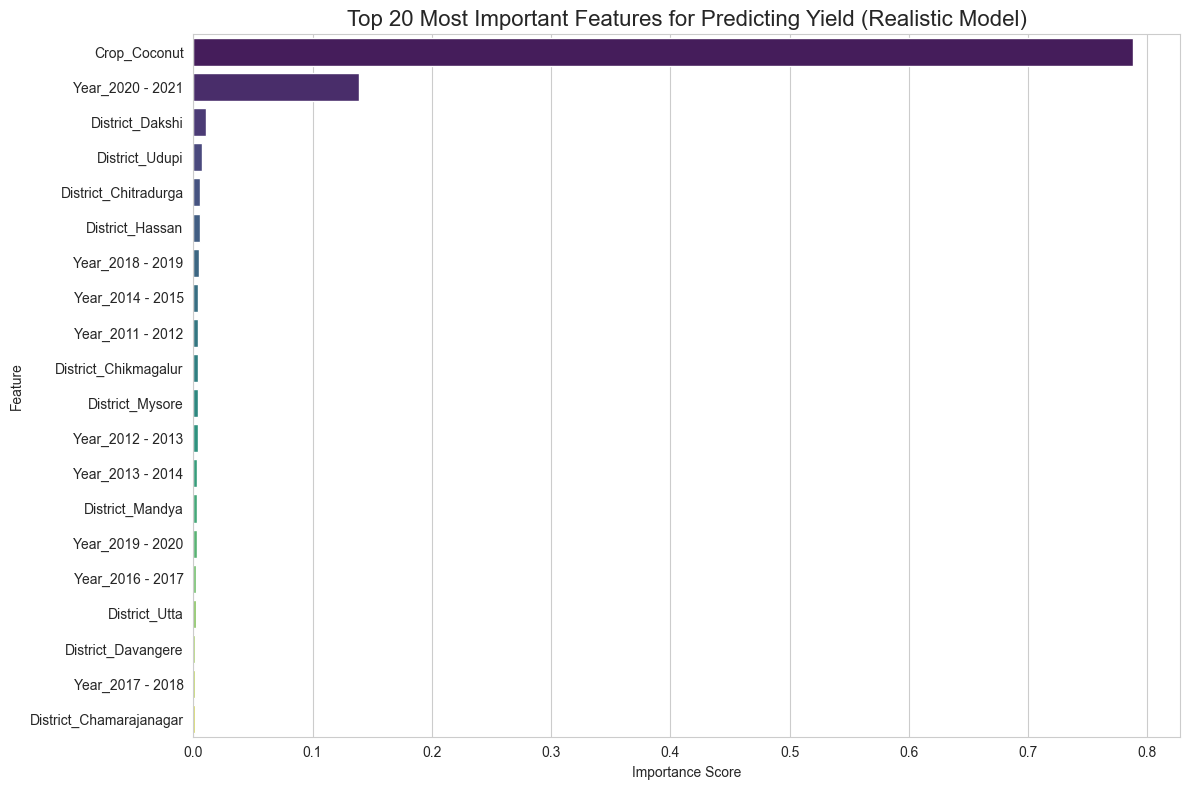

In [5]:
# --- PART 2: MACHINE LEARNING MODEL (REALISTIC VERSION) ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb

print("\n## 2. Starting REALISTIC Machine Learning Model Build...")

# Drop rows where the target variable 'Yield (Kg/Ha)' is missing
df_model = df.dropna(subset=['Yield (Kg/Ha)'])

# Define features (X) and target (y)
# We drop 'Area (Hectare)' and 'Production (Tonnes)' to prevent data leakage
features = df_model.drop(columns=['Yield (Kg/Ha)', 'Production (Tonnes)', 'Area (Hectare)'])
target = df_model['Yield (Kg/Ha)']

# One-Hot Encode the categorical features
features_encoded = pd.get_dummies(features, columns=['State', 'District', 'Year', 'Crop'], drop_first=True)

X = features_encoded
y = target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Train the XGBoost model
print("\nTraining the XGBoost Regressor model...")
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgboost_model.fit(X_train, y_train)
print("Model training complete.")

# Evaluate the model
print("\n## 3. Evaluating Model Performance...")
y_pred = xgboost_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f} Kg/Ha")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} Kg/Ha")

# Visualize Feature Importance
print("\n## 4. Visualizing Feature Importance...")
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgboost_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20), palette='viridis')
plt.title('Top 20 Most Important Features for Predicting Yield (Realistic Model)', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('realistic_feature_importance.png')
print("Saved realistic feature importance plot as realistic_feature_importance.png")
plt.show()

# Explain the Model's Predictions with SHAP
This block uses the shap library to analyze your best_model and create plots that explain which features are most important and how they impact the predictions.



## 5. Starting Hyperparameter Tuning...
Running GridSearchCV... This may take a few minutes.
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best parameters found: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100}

## 6. Evaluating TUNED Model Performance...
Tuned R-squared (R²): 0.9845
Tuned Mean Absolute Error (MAE): 13.29 Kg/Ha
Tuned Root Mean Squared Error (RMSE): 142.24 Kg/Ha

## 7. Generating Model Explanations with SHAP...
Generating SHAP Summary Plot...


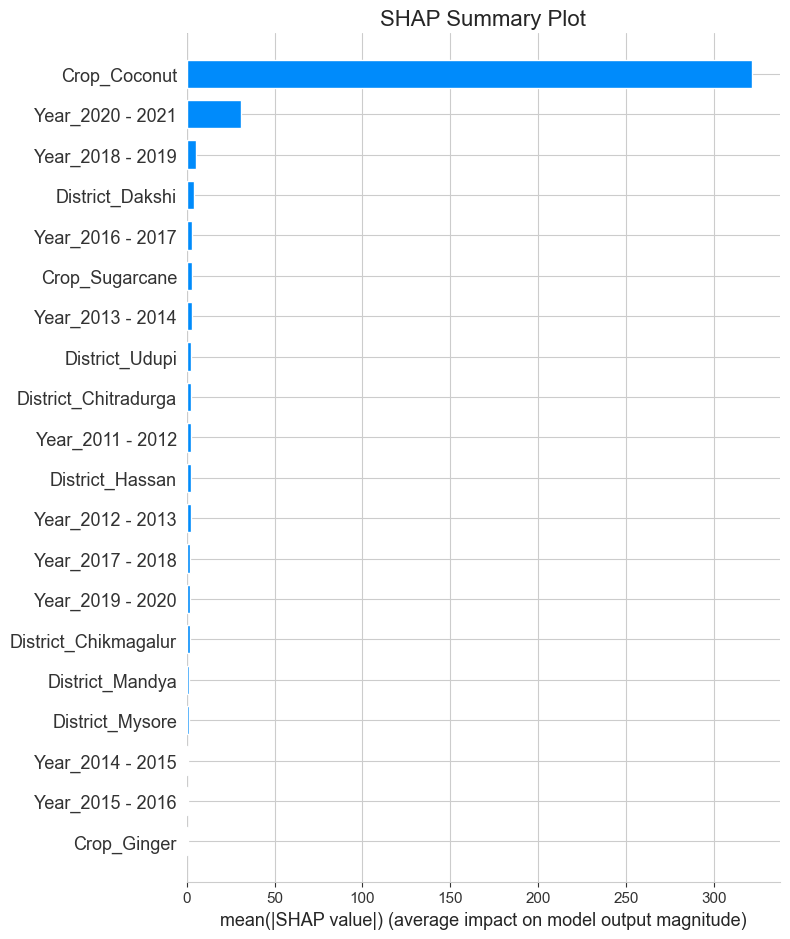

This plot shows the overall most important features.

Generating SHAP Beeswarm Plot...


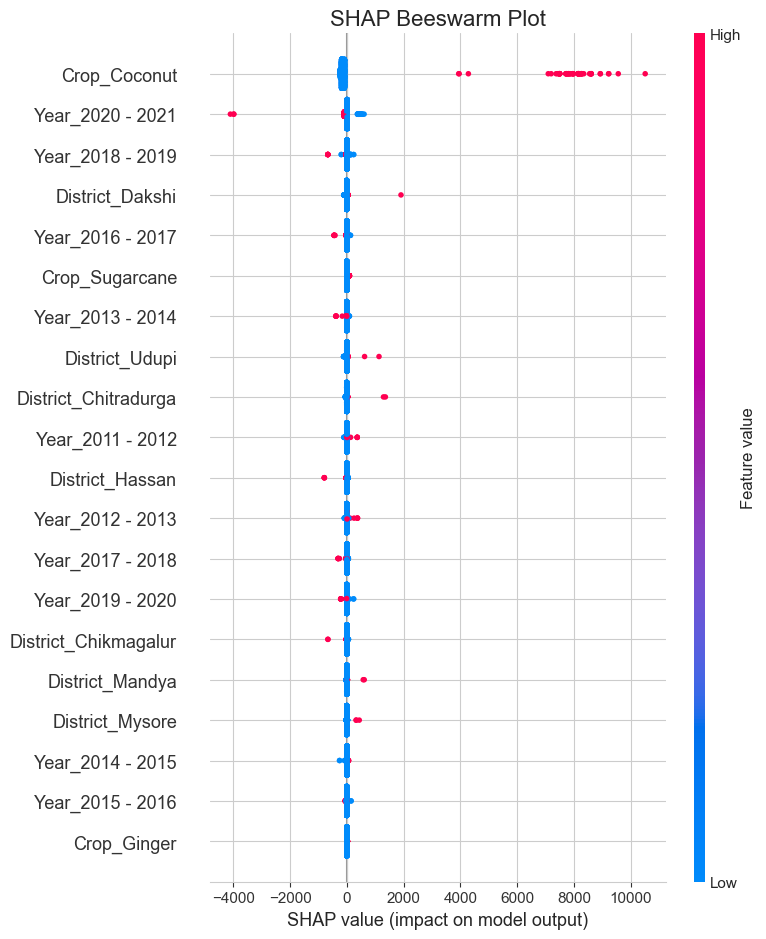

This plot shows not only the importance but also the *impact* of each feature.

Generating SHAP Waterfall Plot for a single prediction...


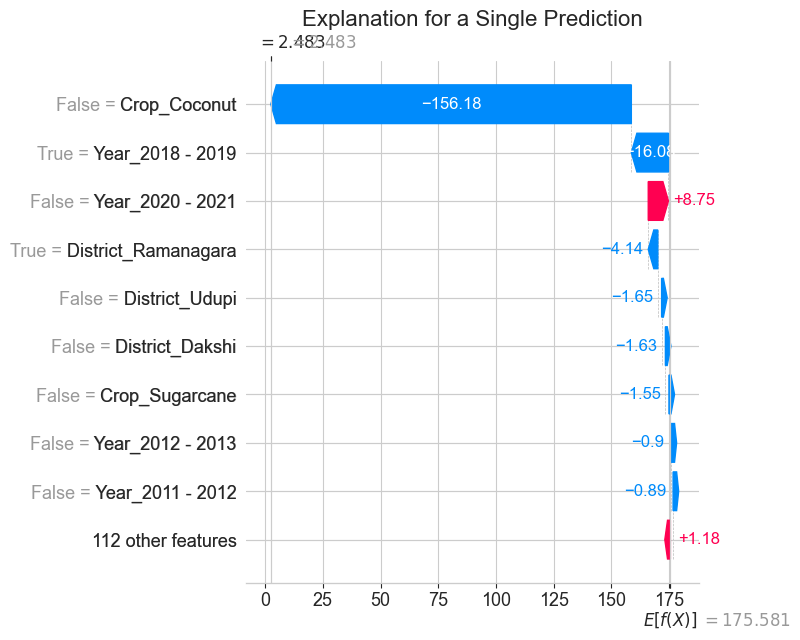

This plot shows exactly how each feature contributed to one specific prediction.


In [8]:
# Install the shap library if it's not already installed
!pip install shap

# --- PART 3: HYPERPARAMETER TUNING & MODEL EXPLANATION ---
import shap
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

print("\n## 5. Starting Hyperparameter Tuning...")

# --- Hyperparameter Tuning ---
# Define a smaller parameter grid for faster tuning
param_grid = {
    'max_depth': [5, 7],
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05]
}

# Initialize the XGBoost model
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='r2')

# Fit the grid search to the data
print("Running GridSearchCV... This may take a few minutes.")
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_
print(f"\nBest parameters found: {grid_search.best_params_}")


# --- Re-evaluate with the Tuned Model ---
print("\n## 6. Evaluating TUNED Model Performance...")
y_pred_tuned = best_model.predict(X_test)
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print(f"Tuned R-squared (R²): {r2_tuned:.4f}")
print(f"Tuned Mean Absolute Error (MAE): {mae_tuned:.2f} Kg/Ha")
print(f"Tuned Root Mean Squared Error (RMSE): {rmse_tuned:.2f} Kg/Ha")


# --- Model Explanation with SHAP ---
print("\n## 7. Generating Model Explanations with SHAP...")

# Create a SHAP explainer object for our tuned model
explainer = shap.TreeExplainer(best_model)
# Create a full SHAP Explanation object, which is the modern approach
shap_explanation = explainer(X_test)

# --- The rest of the plots are updated to use the new object ---

# 1. SHAP Summary Plot (Global Feature Importance)
print("Generating SHAP Summary Plot...")
plt.title("SHAP Summary Plot", fontsize=16)
# The summary plot can still use the .values attribute for the bar plot
shap.summary_plot(shap_explanation.values, X_test, plot_type="bar", show=False)
plt.savefig('shap_summary.png')
plt.show()
print("This plot shows the overall most important features.")


# 2. SHAP Beeswarm Plot (Detailed Feature Impact)
print("\nGenerating SHAP Beeswarm Plot...")
plt.title("SHAP Beeswarm Plot", fontsize=16)
# The main summary plot (beeswarm) works best with the full object
shap.summary_plot(shap_explanation, X_test, show=False)
plt.savefig('shap_beeswarm.png')
plt.show()
print("This plot shows not only the importance but also the *impact* of each feature.")


# 3. SHAP Waterfall Plot (Explaining a Single Prediction)
print("\nGenerating SHAP Waterfall Plot for a single prediction...")
# **CORRECTED LINE**: The waterfall plot now takes a single slice of the Explanation object
shap.plots.waterfall(shap_explanation[0], show=False)
plt.title("Explanation for a Single Prediction", fontsize=16)
plt.tight_layout()
plt.savefig('shap_waterfall.png')
plt.show()
print("This plot shows exactly how each feature contributed to one specific prediction.")

# Save the Model
This block saves your trained best_model and the necessary column data to files

In [9]:
import joblib

# Let's assume 'best_model' is your tuned XGBoost model from the previous step
# and 'X_train' is your final training data with all the encoded columns.

# Save the model to a file
model_filename = 'agrisense_yield_predictor.joblib'
joblib.dump(best_model, model_filename)

# Save the columns from the training data. This is CRUCIAL for making predictions on new data later.
training_columns_filename = 'training_columns.joblib'
joblib.dump(X_train.columns, training_columns_filename)

print(f"Model saved as: {model_filename}")
print(f"Training columns saved as: {training_columns_filename}")

Model saved as: agrisense_yield_predictor.joblib
Training columns saved as: training_columns.joblib


# Create a Prediction Function
It defines the predict_yield function that loads these files to make predictions on new data.

In [10]:
import joblib
import pandas as pd

def predict_yield(new_data):
    """
    Loads the saved model and predicts the yield for new, unseen data.
    
    Args:
    new_data (dict or pd.DataFrame): A dictionary or DataFrame with the new data.
                                     Example: {'District': ['Hassan'], 'Year': ['2023 - 2024'], 'Crop': ['Sugarcane']}
    
    Returns:
    float: The predicted yield in Kg/Ha.
    """
    try:
        # Load the trained model and the training columns
        model = joblib.load('agrisense_yield_predictor.joblib')
        training_columns = joblib.load('training_columns.joblib')
        
        # Convert new data into a DataFrame
        new_df = pd.DataFrame(new_data)
        
        # --- Preprocessing ---
        # Perform the same one-hot encoding as before
        new_df_encoded = pd.get_dummies(new_df, columns=['District', 'Year', 'Crop'], drop_first=True)
        
        # Align the columns of the new data with the training data
        # This adds any missing columns (with a value of 0) and removes any extra ones.
        final_df = new_df_encoded.reindex(columns=training_columns, fill_value=0)
        
        # --- Prediction ---
        prediction = model.predict(final_df)
        
        return prediction[0]

    except FileNotFoundError:
        return "Error: Model files not found. Please run the training script first."
    except Exception as e:
        return f"An error occurred: {e}"

# --- Example Usage ---
# Let's predict the yield for a new scenario
hypothetical_data = {
    'District': ['Hassan'],
    'Year': ['2024 - 2025'], # A future year
    'Crop': ['Sugarcane']
}

predicted_yield = predict_yield(hypothetical_data)
print(f"\n--- Prediction Demo ---")
print(f"Input Data: {hypothetical_data}")
print(f"Predicted Yield: {predicted_yield:.2f} Kg/Ha")


--- Prediction Demo ---
Input Data: {'District': ['Hassan'], 'Year': ['2024 - 2025'], 'Crop': ['Sugarcane']}
Predicted Yield: 2.48 Kg/Ha
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   0.3s
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time=   0.4s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=200; total time=   0.3s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.4s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=100; total time=   0.2s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.4s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.05, max_depth=7, n_estimators=200; total time=   0.3s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.4s
[CV] END ..learning_rate=0.05, max_depth=5, n_estima

# LIVE DEMO
This final block creates the simple demo interface. You can edit the input variables in the code to test different scenarios and get live predictions from your saved model.

In [16]:
!pip install -q ipywidgets jupyterlab_widgets

In [2]:
# --- PART 1: IMPORTS & DATA CLEANING ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("## 1. Starting Data Cleaning and Reshaping...")
try:
    raw_df = pd.read_csv('historical_data_2010-2020.csv')
except FileNotFoundError:
    print("Error: The file 'historical_data_2010-2020.csv' was not found.")
    exit()

raw_df['State'].ffill(inplace=True)
raw_df['District'].ffill(inplace=True)
raw_df['Year'].ffill(inplace=True)
raw_df = raw_df.drop([0, 1]).reset_index(drop=True)

tidy_data = []
for i in range(3, raw_df.shape[1], 3):
    if i + 2 >= raw_df.shape[1]: continue
    header_info = pd.read_csv('historical_data_2010-2020.csv', nrows=1).columns[i]
    crop_name = header_info.split('/')[0].strip()
    area_col, prod_col, yield_col = raw_df.columns[i], raw_df.columns[i+1], raw_df.columns[i+2]
    crop_df = raw_df[['State', 'District', 'Year', area_col, prod_col, yield_col]].copy()
    crop_df['Crop'] = crop_name
    crop_df.rename(columns={
        area_col: 'Area (Hectare)', prod_col: 'Production (Tonnes)', yield_col: 'Yield (Kg/Ha)'
    }, inplace=True)
    tidy_data.append(crop_df)

df = pd.concat(tidy_data, ignore_index=True)

df.dropna(subset=['Area (Hectare)', 'Production (Tonnes)', 'Yield (Kg/Ha)'], how='all', inplace=True)
for col in ['Area (Hectare)', 'Production (Tonnes)', 'Yield (Kg/Ha)']:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
df['State'] = df['State'].str.split('. ').str[1]
df['District'] = df['District'].str.split('. ').str[1]
print("Data cleaning complete. DataFrame 'df' is created.")

# --- PART 2: TRAIN AND SAVE THE MODEL ---
print("\n## 2. Training and Saving the Model...")
df_model = df.dropna(subset=['Yield (Kg/Ha)'])
features = df_model.drop(columns=['Yield (Kg/Ha)', 'Production (Tonnes)', 'Area (Hectare)'])
target = df_model['Yield (Kg/Ha)']
features_encoded = pd.get_dummies(features, columns=['State', 'District', 'Year', 'Crop'], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(features_encoded, target, test_size=0.2, random_state=42)

# Using the best parameters we found earlier
best_params = {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
final_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
final_model.fit(X_train, y_train)

joblib.dump(final_model, 'agrisense_yield_predictor.joblib')
joblib.dump(X_train.columns, 'training_columns.joblib')
print("Model and training columns have been saved.")

# --- PART 3: DEFINE THE PREDICTION FUNCTION ---
def predict_yield(new_data):
    try:
        model = joblib.load('agrisense_yield_predictor.joblib')
        training_columns = joblib.load('training_columns.joblib')
        new_df = pd.DataFrame(new_data)
        new_df_encoded = pd.get_dummies(new_df, columns=['District', 'Year', 'Crop'], drop_first=True)
        final_df = new_df_encoded.reindex(columns=training_columns, fill_value=0)
        prediction = model.predict(final_df)
        return prediction[0]
    except FileNotFoundError:
        return "Error: Model files not found."

print("\nSetup complete. You can now run the interactive demo cell.")

## 1. Starting Data Cleaning and Reshaping...
Data cleaning complete. DataFrame 'df' is created.

## 2. Training and Saving the Model...
Model and training columns have been saved.

Setup complete. You can now run the interactive demo cell.


In [4]:
# --- PART 4: REVISED INTERACTIVE DEMO (SIMPLE FORM) ---
# Ensure the 'predict_yield' function and its model files are available

print("--- AgriSense Yield Prediction Demo ---")
print("Instructions: Edit the values for the three variables below and run the cell.")

# ================================================================
# V V V V V V V V V  EDIT YOUR INPUTS HERE  V V V V V V V V V V V V
# ================================================================

district_input = "Hassan"
crop_input = "Sugarcane"
year_input = "2019 - 2020"

# ================================================================
# ^ ^ ^ ^ ^ ^ ^ ^ ^  NO NEED TO EDIT BELOW THIS LINE ^ ^ ^ ^ ^ ^ ^ ^
# ================================================================

# --- Run Prediction ---
# Create the dictionary for the prediction function from your inputs
prediction_data = {
    'District': [district_input],
    'Crop': [crop_input],
    'Year': [year_input]
}

# Call your prediction function
predicted_yield = predict_yield(prediction_data)

# Display the result
print("\n" + "="*25)
print(f"  PREDICTED YIELD FOR:")
print(f"  District: {district_input}")
print(f"  Crop: {crop_input}")
print(f"  Year: {year_input}")
print("="*25)
print(f"  {predicted_yield:.2f} Kg/Ha")
print("="*25)

--- AgriSense Yield Prediction Demo ---
Instructions: Edit the values for the three variables below and run the cell.

  PREDICTED YIELD FOR:
  District: Hassan
  Crop: Sugarcane
  Year: 2019 - 2020
  1.01 Kg/Ha
